In [1]:
import torch

from model import *
from data import *

import itertools

In [2]:
config = Config().load("config.json")

In [3]:
def trainModel(config, modelClass, dataClass, objective, epochs, criterion: dict[str: nn.Module]):
    dataset = dataClass(config)

    dataset.info(dataset[0])

    trainSize = len(dataset)
    # TODO: More stratified subsets using dataset.lengths and geographic information
    train = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit)))
    test = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit), trainSize))

    trainSampler = GraphSizeSampler(train)
    testSampler = GraphSizeSampler(test)

    train = DataLoader(train, batch_sampler=trainSampler, generator=torch.Generator(device))
    test = DataLoader(test, batch_sampler=testSampler, generator=torch.Generator(device))

    dataset.info(next(iter(train)))

    model = modelClass(config)
    print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")
    print(f"Dataset has {len(dataset)} samples")
    print(next(model.parameters()).is_cuda)

    precision, recall, mae = CMALPrecision(), CMALRecall(), CMALNormalizedMeanAbsolute()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    testIter = itertools.cycle(test)

    for epoch in range(epochs):
        progress = 0
        for inputs, targets in train:
            model.train()
            optimizer.zero_grad()

            history, future = targets.dischargeHistory, targets.dischargeFuture
            thresholds, deviations = targets.thresholds, targets.deviation
            hindcast, forecast = model(inputs)
            loss = objective(forecast, future)
            trainLoss = loss.item()

            # trainPrecision, trainRecall = precision(forecast, future, thresholds), recall(forecast, future, thresholds)
            # trainMAE = mae(forecast, future, deviations)

            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

            with torch.no_grad():
                model.eval()
                inputs, targets = next(testIter)

                history, future, thresholds = targets.dischargeHistory, targets.dischargeFuture, targets.thresholds
                hindcast, forecast = model(inputs)
                loss = objective(forecast, future)
                testLoss = loss.detach().item()

                # testPrecision, testRecall = precision(forecast, future, thresholds), recall(forecast, future, thresholds)
                # testMAE = mae(forecast, future, deviations)

            torch.cuda.empty_cache()

            progress += 1
            # print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss} | Train Precision: {precision} | Train Recall: {recall}")
            print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss} | Test Loss: {testLoss}", end="")
        print()

    return model

Loading GeoPandas...
GeoPandas Loaded
2544/2544 GRDC files loaded
9640/9640 ERA5 files loaded
Total empty basins: 37
57622/57646 Basin Structures Appended to Graph
Upstream Basins Compiled | 1.0 | 17.43485477178423
Upstream Structures Compiled
Structure Tensors Complete
Index Mapping Complete
Static Input Scaling Complete

        Total Samples: 29254761
        Era5 History: torch.Size([1, 120, 7]) torch.float32
        Era5 Future: torch.Size([1, 7, 7]) torch.float32
        Basin Continuous: torch.Size([1, 277]) torch.float32
        Basin Discrete: torch.Size([1, 10]) torch.int64
        Structure: torch.Size([2, 1]) torch.int64
        River Continuous: torch.Size([258]) torch.float32
        River Discrete: torch.Size([14]) torch.int64
        Discharge History: torch.Size([120]) torch.float32
        Discharge Future: torch.Size([7]) torch.float32
        Thresholds: torch.Size([4]) torch.float32
        


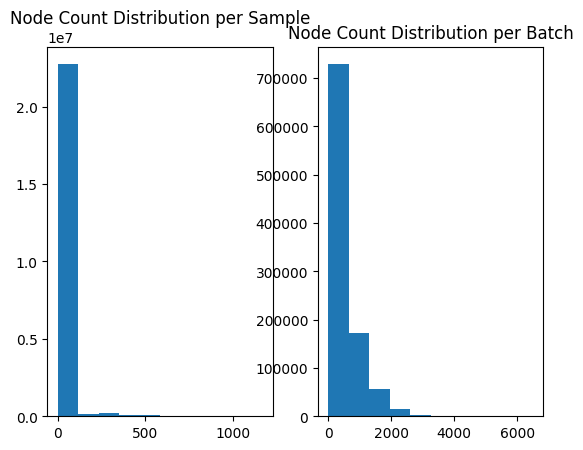

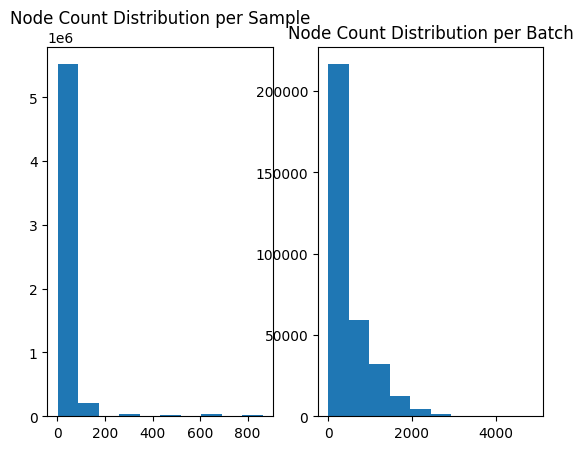


        Total Samples: 29254761
        Era5 History: torch.Size([495, 120, 7]) torch.float32
        Era5 Future: torch.Size([495, 7, 7]) torch.float32
        Basin Continuous: torch.Size([495, 277]) torch.float32
        Basin Discrete: torch.Size([495, 10]) torch.int64
        Structure: torch.Size([2, 977]) torch.int64
        River Continuous: torch.Size([13, 258]) torch.float32
        River Discrete: torch.Size([13, 14]) torch.int64
        Discharge History: torch.Size([13, 120]) torch.float32
        Discharge Future: torch.Size([13, 7]) torch.float32
        Thresholds: torch.Size([13, 4]) torch.float32
        
Model has 1127544 parameters
Dataset has 29254761 samples
True
2515/977742 | 0.257% |  Train Loss: nan | Test Loss: nan| Test Loss: nan.46719360351562516

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.37 GiB is allocated by PyTorch, and 265.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [4]:
metrics = {
    "Precision": CMALLoss()
}

trainModel(config, InundationStation, InundationData, CMALLoss(), epochs=10, criterion=metrics)